In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import seaborn as sns
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    "figure.figsize": (5, 3),
    "text.usetex": True,
    "text.latex.preamble": r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
    """,
}

size = 17

sns.set_theme(style="whitegrid", rc={
    "pdf.fonttype": 42,
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 15,
    "axes.titlesize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 12,
    "legend.fontsize": 16,
    "font.weight": "bold",
})

In [2]:
results_path = Path('results')
compact_table_path_uncivil = results_path / 'compact_result_table_uncivil_without_duplicates.xlsx'
compact_table_path_civil = results_path / 'compact_result_table_civil_without_duplicates.xlsx'

uncivil = pd.read_excel(compact_table_path_uncivil)
uncivil = uncivil.ffill()
uncivil = uncivil.loc[~uncivil['Model'].isin(['toxicr', 'refined_model']).values]
uncivil = uncivil.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-score'})
uncivil_sem_combinacoes = uncivil.loc[~uncivil['Strategy'].str.contains('role_based_')].copy()  # excluir combinações com role-based

civil = pd.read_excel(compact_table_path_civil)
civil = civil.ffill()
civil = civil.loc[~civil['Model'].isin(['toxicr', 'refined_model']).values]
civil = civil.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-score'})
civil_sem_combinacoes = civil.loc[~civil['Strategy'].str.contains('role_based_')].copy()  # excluir combinações com role-based

uncivil_data = uncivil_sem_combinacoes.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean().reset_index().copy()
civil_data = civil_sem_combinacoes.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean().reset_index().copy()

models = ['phi4:14b', 'deepseek-r1:14b', 'mistral-nemo:12b', 'gemma2:9b', 'llama3.1:8b', 'deepseek-r1:8b', 'gemma:7b', 'mistral:7b', 'llama3.2:3b', 'gpt-4o-mini']

models = [m.replace(':', '_') for m in models]

uncivil_data = uncivil_data.set_index('Model').loc[models, ['Precision', 'Recall', 'F1-score']].reset_index()
civil_data = civil_data.set_index('Model').loc[models, ['Precision', 'Recall', 'F1-score']].reset_index()

with pd.ExcelWriter(results_path / 'new_rq1_table_means.xlsx', engine='xlsxwriter') as writer:
    uncivil_data.to_excel(writer, sheet_name='Uncivil', index=False)
    civil_data.to_excel(writer, sheet_name='Civil', index=False)

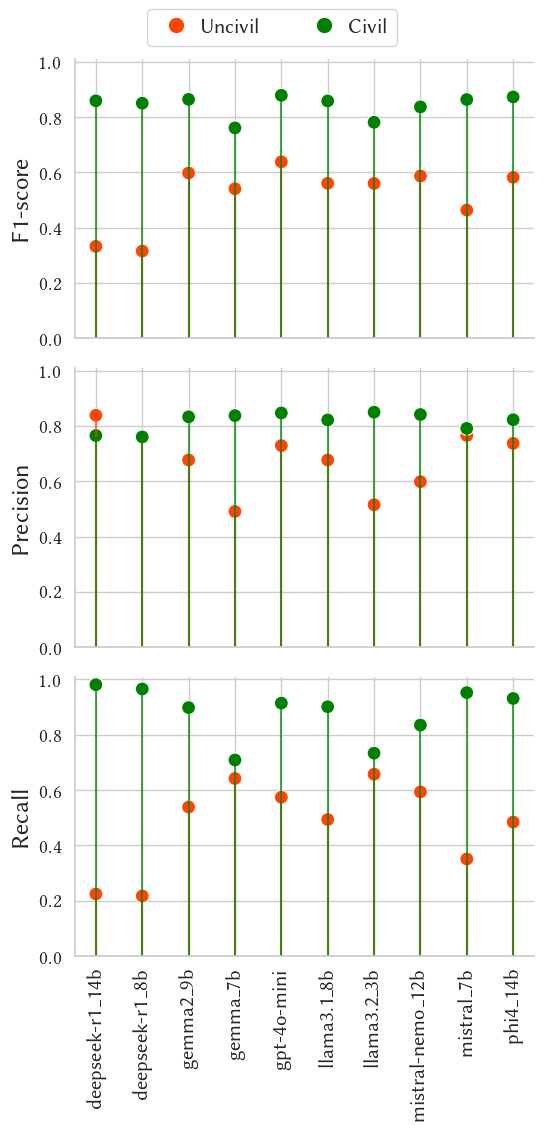

In [ ]:

##### Metrics in lines
mpl.rcParams.update(rc_fonts)

# Grouping and preparing data
uncivil_data = uncivil_sem_combinacoes.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean().reset_index().copy()
civil_data = civil_sem_combinacoes.groupby('Model')[['F1-score', 'Precision', 'Recall']].mean().reset_index().copy()

uncivil_data["Class"] = "Uncivil"
civil_data["Class"] = "Civil"

df = pd.concat([uncivil_data, civil_data])
df_long = df.melt(id_vars=["Model", "Class"], var_name="Metric", value_name="Score")

# Defining model order (keeping the original)
model_order = df["Model"].unique()

sns.set_theme(style="whitegrid")

colors = {"Uncivil": "orangered", "Civil": "green"}

# lollipop plot 
def lollipop(data, **kwargs):
    ax = plt.gca()
    for _, row in data.iterrows():
        ax.vlines(row["Model"], ymin=0, ymax=row["Score"], color=colors[row["Class"]], alpha=0.7)
    sns.scatterplot(data=data, x="Model", y="Score", hue="Class", palette=colors, s=100, legend=False, ax=ax)

g = sns.FacetGrid(df_long, row="Metric", sharey=True, height=4, aspect=1.4)

g.map_dataframe(lollipop)

g.set_xticklabels(rotation=90, weight='bold', fontsize=16, fontfamily='serif')
g.set_xticklabels(model_order, rotation=90, weight='bold', fontfamily='serif', fontsize=15)
g.set_xlabels("")
g.set_titles("")


for ax, metric in zip(g.axes[:, 0], df_long["Metric"].unique()):
    ax.set_ylabel(metric, weight='bold', fontsize=18, fontfamily='serif')
    for label in ax.get_yticklabels():
        label.set_fontsize(14)
        label.set_fontfamily('serif')
        label.set_fontweight('bold')
    ax.set_ylim(0, 1.01) 


# manual legend
handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in colors.values()]
labels = list(colors.keys())
legend_font = FontProperties(family='serif', weight='bold', size=15)
g.fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, handletextpad=0.2, prop=legend_font)

# final layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  

fig_path = results_path / 'figures'
os.makedirs(fig_path, exist_ok=True)
plt.savefig(fig_path / 'metrics_comparison_rq1_linha.pdf', bbox_inches='tight', dpi=600)

plt.show()


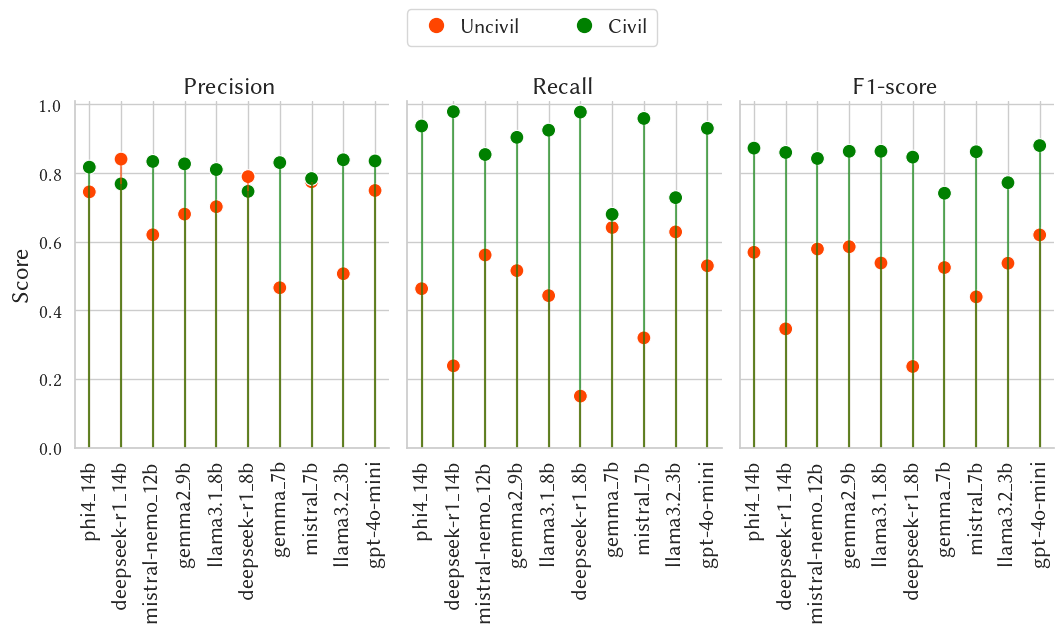

In [ ]:
##### Metrics in columns
mpl.rcParams.update(rc_fonts)

models = ['phi4:14b', 'deepseek-r1:14b', 'mistral-nemo:12b', 'gemma2:9b', 'llama3.1:8b', 'deepseek-r1:8b', 'gemma:7b', 'mistral:7b', 'llama3.2:3b', 'gpt-4o-mini']

models = [m.replace(':', '_') for m in models]

# Grouping and preparing data
uncivil_data = uncivil_sem_combinacoes.groupby('Model')[['Precision', 'Recall', 'F1-score']].mean().loc[models].reset_index().copy()
civil_data = civil_sem_combinacoes.groupby('Model')[['Precision', 'Recall', 'F1-score']].mean().loc[models].reset_index().copy()

uncivil_data["Class"] = "Uncivil"
civil_data["Class"] = "Civil"

df = pd.concat([uncivil_data, civil_data])
df.to_csv(results_path / 'mean_metrics_comparison_rq1.csv', index=False)
df_long = df.melt(id_vars=["Model", "Class"], var_name="Metric", value_name="Score")

# Defining model order (keeping the original)
model_order = df["Model"].unique()

sns.set_theme(style="whitegrid")

colors = {"Uncivil": "orangered", "Civil": "green"}

# lolipop function to plot each point with line
def lollipop(data, **kwargs):
    ax = plt.gca()
    for _, row in data.iterrows():
        ax.vlines(row["Model"], ymin=0, ymax=row["Score"], color=colors[row["Class"]], alpha=0.6)
    sns.scatterplot(data=data, x="Model", y="Score", hue="Class", palette=colors, s=100, legend=False, ax=ax)

# FacetGrid with one column per metric
g = sns.FacetGrid(df_long, col="Metric", sharey=True, height=6, aspect=0.6)

g.map_dataframe(lollipop)

g.set_xticklabels(model_order, rotation=90, weight='bold', fontsize=16, fontfamily='serif')
g.set_titles("")
g.set_xlabels("")


for ax in g.axes[:, 0]:
    ax.set_ylabel("Score", weight='bold', fontsize=18, fontfamily='serif')
    for label in ax.get_yticklabels():
        label.set_fontsize(14)
        label.set_fontfamily('serif')
        label.set_fontweight('bold')
    ax.set_ylim(0, 1.01)  

# columns
for ax, col_value in zip(g.axes[0], df_long["Metric"].unique()):
    ax.set_title(col_value, weight='bold', fontsize=18, fontfamily='serif')

# manual legend
handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in colors.values()]
labels = list(colors.keys())
legend_font = FontProperties(family='serif', weight='bold', size=15)
g.fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.07), ncol=2, handletextpad=0.2, prop=legend_font)

# final layout
plt.tight_layout()
plt.subplots_adjust(top=0.9) 

fig_path = results_path / 'figures'
os.makedirs(fig_path, exist_ok=True)
plt.savefig(fig_path / 'metrics_comparison_rq1.pdf', bbox_inches='tight', dpi=600)

plt.show()


## RQ2

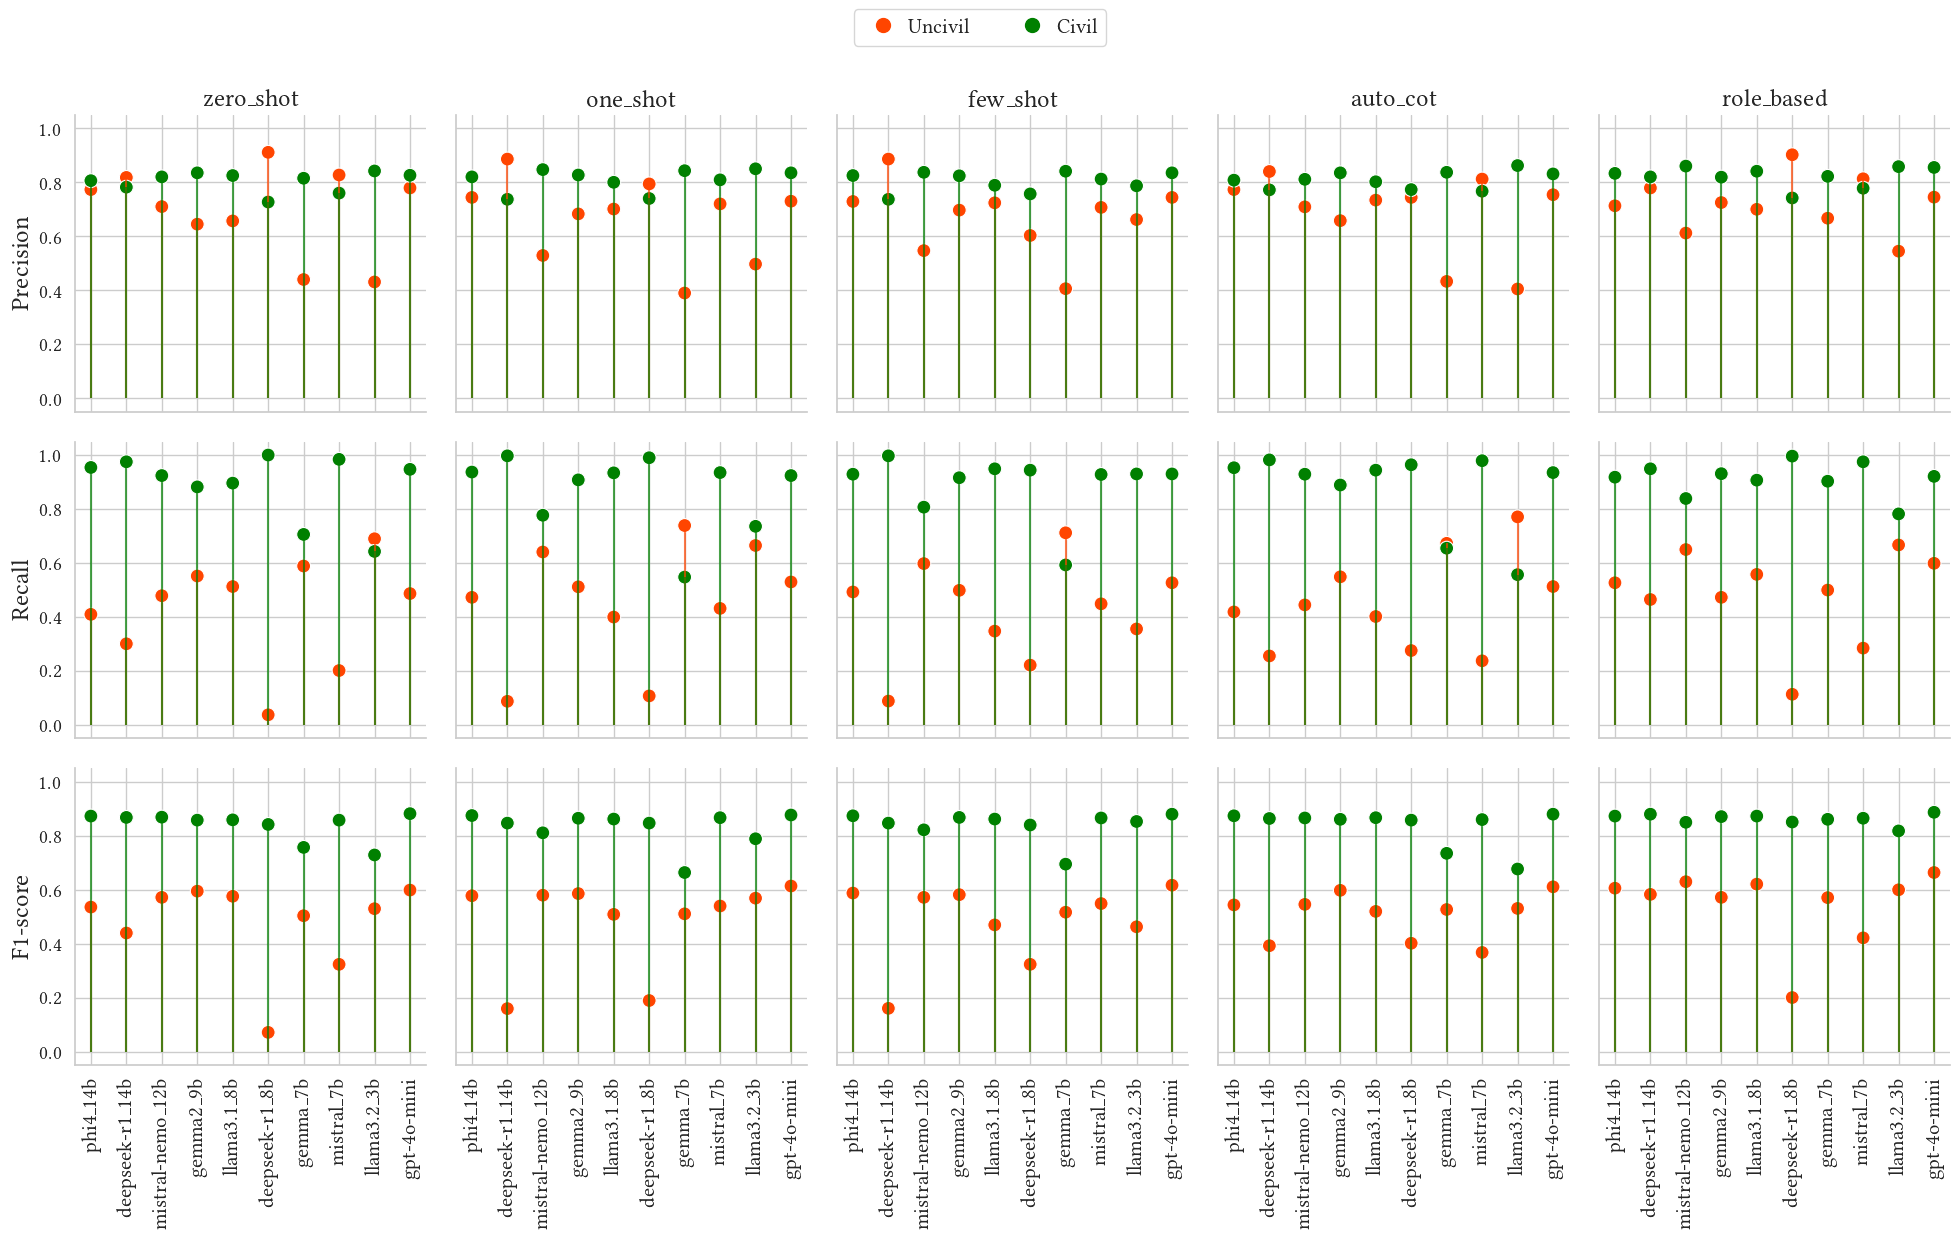

In [ ]:
# Plot
mpl.rcParams.update(rc_fonts)

models = ['phi4:14b', 'deepseek-r1:14b', 'mistral-nemo:12b', 'gemma2:9b', 'llama3.1:8b', 'deepseek-r1:8b', 'gemma:7b', 'mistral:7b', 'llama3.2:3b', 'gpt-4o-mini']

models = [m.replace(':', '_') for m in models]

uncivil_sem_combinacoes["Class"] = "Uncivil"
civil_sem_combinacoes["Class"] = "Civil"

uncivil_sem_combinacoes = uncivil_sem_combinacoes.set_index('Model').loc[models].reset_index()
civil_sem_combinacoes = civil_sem_combinacoes.set_index('Model').loc[models].reset_index()

civil = civil_sem_combinacoes[["Model", "Class", "Strategy", "Precision", "Recall", "F1-score"]]
uncivil = uncivil_sem_combinacoes[["Model", "Class", "Strategy", "Precision", "Recall", "F1-score"]]

df = pd.concat([uncivil, civil])
df_long = df.melt(id_vars=["Model", "Class", "Strategy"], var_name="Metric", value_name="Score")

# sns.set_theme(style="whitegrid", font_scale=1.2)

model_order = df["Model"].unique()

# FacetGrid para cada métrica
g = sns.FacetGrid(df_long, row='Metric', col="Strategy", sharey=True, sharex=True, height=4, aspect=1)
colors = {"Uncivil": "orangered", "Civil": "green"}

def lollipop(data, **kwargs):
    for _, row in data.iterrows():
        plt.vlines(row["Model"], ymin=0, ymax=row["Score"], color=colors[row["Class"]], alpha=0.7)
    sns.scatterplot(data=data, x="Model", y="Score", hue="Class", palette=colors, s=100, legend=False)

g.map_dataframe(lollipop)
# g.set_xticklabels(model_order, rotation=90, weight='bold', fontfamily='serif', fontsize=15)
g.set_xticklabels(model_order, rotation=90, weight='bold', fontfamily='serif', fontsize=15)#
g.set_titles("")
g.set_xlabels("")

# colunas
for ax, col_value in zip(g.axes[0], df_long["Strategy"].unique()):
    # ax.set_title(col_value, weight='bold', fontsize=18, fontfamily='serif')
    ax.set_title(col_value, weight='bold', fontsize=18, fontfamily='serif')

# linhas
for ax, metric in zip(g.axes[:, 0], df_long["Metric"].unique()):
    # ax.set_ylabel(metric, weight='bold', fontsize=18, fontfamily='serif')
    ax.set_ylabel(metric, weight='bold', fontsize=18, fontfamily='serif')

# ytick labels
for ax in g.axes.flatten():
    for label in ax.get_yticklabels():
        label.set_fontsize(14)
        # label.set_fontfamily('serif')
        label.set_fontfamily('serif')
        label.set_fontweight('bold')
        
#g.set_axis_labels("Model", "Score")

handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in colors.values()]
labels = list(colors.keys())
# legend_font = FontProperties(family='serif', weight='bold', size=15)
legend_font = FontProperties(weight='bold', size=15)
g.figure.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, handletextpad=0.2, prop=legend_font)

plt.tight_layout()

fig_path = results_path / 'figures'
os.makedirs(fig_path, exist_ok=True)
plt.savefig(fig_path / 'metrics_comparison_rq2.pdf', bbox_inches='tight', dpi=600)

plt.show()

## RQ3

<Axes: >

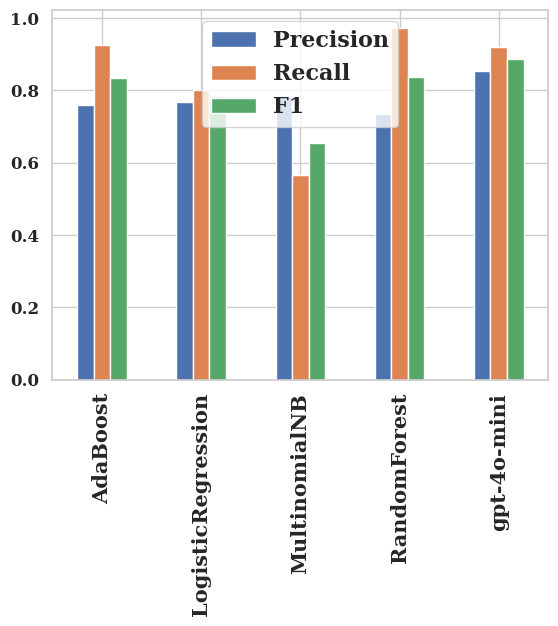

In [24]:
results_path = Path('results')    
ml_results_path = results_path / 'ml_models'

ml_civil_path = ml_results_path / 'civil_metric_means_results.csv'
ml_uncivil_path = ml_results_path / 'uncivil_metric_means_results.csv'

civil_ml = pd.read_csv(ml_civil_path, index_col=0)
uncivil_ml = pd.read_csv(ml_uncivil_path, index_col=0)

civil_ml.loc['gpt-4o-mini', :] = civil.loc[(civil['Strategy'] == 'role_based') & (civil['Model'] == 'gpt-4o-mini'), ['Precision', 'Recall', 'F1-score']].values
uncivil_ml.loc['gpt-4o-mini', :] = uncivil.loc[(uncivil['Strategy'] == 'role_based') & (uncivil['Model'] == 'gpt-4o-mini'), ['Precision', 'Recall', 'F1-score']].values

civil_ml.plot(kind='bar')